In [ ]:
#google drive connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#!pip install scikit-learn --upgrade
from keras import Model
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [2]:
#import data
df1 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_valerio.csv')
df2 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero.csv')
df3 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giovanni.csv')
df4 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_2.csv')
df5 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_beste.csv')
df6 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_christian.csv')

In [3]:
#removing all the data before the start of the protocol - run only one time!!
df1 = df1[df1.iloc[:, 9] != 'Null']
df2 = df2[df2.iloc[:, 9] != 'Null']
df3 = df3[df3.iloc[:, 9] != 'Null']
df4 = df4[df4.iloc[:, 9] != 'Null']
df5 = df5[df5.iloc[:, 9] != 'Null']
df6 = df6[df6.iloc[:, 9] != 'Null']
#------removing first value for capturing variation of the data respect to the starting moment
def subtract_first_row(df):
    first_row_numeric = df.iloc[0, :-1]
    df_subtracted = df.copy()
    df_subtracted.iloc[:, :-1] = df_subtracted.iloc[:, :-1].subtract(first_row_numeric, axis='columns')
    return df_subtracted

df1 = subtract_first_row(df1)
df2 = subtract_first_row(df2)
df3 = subtract_first_row(df3)
df4 = subtract_first_row(df4)
df5 = subtract_first_row(df5)
df6 = subtract_first_row(df6)

#----- training and test dataframe

df_train = pd.concat([df1, df2, df3, df4])
df_val = df5
df_test = df6

In [4]:
#feature selection - not on the sequence!!!!


# Separa le feature (X) dall'etichetta (y)
X_train_df = df_train.iloc[:, :-1]  # Tutte le colonne tranne l'ultima (l'etichetta)
y_train_df = df_train.iloc[:, -1]   # L'ultima colonna (l'etichetta)

# Crea il modello Random Forest
model = RandomForestClassifier()

# Crea il selettore di feature
selector = SelectFromModel(model, max_features = 3)

# Adatta il selettore ai dati
selector.fit(X_train_df, y_train_df)

# Ottieni le feature selezionate
X_train_selected = selector.transform(X_train_df)

# Ottieni gli indici delle feature selezionate
selected_feature_indices = selector.get_support(indices=True)

# Stampa gli indici delle feature più rilevanti
print("Indici delle feature più rilevanti:", selected_feature_indices)

# Se vuoi ottenere i nomi delle feature:
feature_names = X_train_df.columns
selected_feature_names = [feature_names[i] for i in selected_feature_indices]
print("Nomi delle feature più rilevanti:", selected_feature_names)
# Aggiungi 'label' alla lista delle feature selezionate
selected_feature_names.append('Label')  # Assicurati che 'label' sia il nome della tua colonna di etichette

# Crea i nuovi DataFrame
df_train = df_train[selected_feature_names]
df_val = df_val[selected_feature_names]
df_test = df_test[selected_feature_names]



Indici delle feature più rilevanti: [0 1 2]
Nomi delle feature più rilevanti: ['Eulerx', 'Eulery', 'Eulerz']


In [5]:
#pattern-time series
window_size = 30 #n.samples (30 = 1s sequence) hyperparameter?
n_features = len(df_train.columns) -1
n_classes = df1['Label'].nunique()
def create_windows(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size, :-1].values)
        y.append(data.iloc[i+window_size-1, -1])
    return np.array(X), np.array(y)


In [6]:
#dataset and scaling
X_train, y_train = create_windows(df_train, window_size)
y_train = to_categorical(y_train, num_classes=n_classes)
X_test, y_test = create_windows(df_test, window_size)
y_test = to_categorical(y_test, num_classes=n_classes)
X_val, y_val = create_windows(df_val, window_size)
y_val = to_categorical(y_val, num_classes=n_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')


scaler = MinMaxScaler()
# Reshape to 2D for scaling
X_train_2D = X_train.reshape(X_train.shape[0], -1)
X_val_2D = X_val.reshape(X_val.shape[0], -1)
X_test_2D = X_test.reshape(X_test.shape[0], -1)

# Scale the data - after the windowing!
X_train_scaled = scaler.fit_transform(X_train_2D)
X_val_scaled = scaler.transform(X_val_2D)
X_test_scaled = scaler.transform(X_test_2D)

# Reshape back to 3D for the LSTM
X_train = X_train_scaled.reshape(X_train.shape)
X_val = X_val_scaled.reshape(X_val.shape)
X_test = X_test_scaled.reshape(X_test.shape)

#noise_factor = 0.05
#X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
# concatenate X_train_noisy with X_train
#X_train_augmented = np.concatenate((X_train, X_train_noisy), axis=0)
#y_train_augmented = np.concatenate((y_train, y_train), axis=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
#print(X_train_augmented.shape)
#print(y_train_augmented.shape)

(44285, 20, 2)
(15888, 20, 2)
(44285, 4)
(15888, 4)
(14821, 20, 2)
(14821, 4)


Epoch 1/50
944/944 [==============================] - 18s 17ms/step - loss: 1.2103 - accuracy: 0.4111 - val_loss: 0.9694 - val_accuracy: 0.5532
Epoch 2/50
944/944 [==============================] - 15s 16ms/step - loss: 0.9372 - accuracy: 0.5783 - val_loss: 0.8569 - val_accuracy: 0.6149
Epoch 3/50
944/944 [==============================] - 16s 17ms/step - loss: 0.8941 - accuracy: 0.6027 - val_loss: 0.8395 - val_accuracy: 0.6483
Epoch 4/50
944/944 [==============================] - 15s 16ms/step - loss: 0.9428 - accuracy: 0.5937 - val_loss: 0.9990 - val_accuracy: 0.5838
Epoch 5/50
944/944 [==============================] - 16s 17ms/step - loss: 0.8718 - accuracy: 0.6299 - val_loss: 0.8261 - val_accuracy: 0.6619
Epoch 6/50
944/944 [==============================] - 15s 16ms/step - loss: 1.2221 - accuracy: 0.4426 - val_loss: 1.2316 - val_accuracy: 0.4220
Epoch 7/50
944/944 [==============================] - 15s 16ms/step - loss: 1.0224 - accuracy: 0.5461 - val_loss: 0.9336 - val_accuracy:

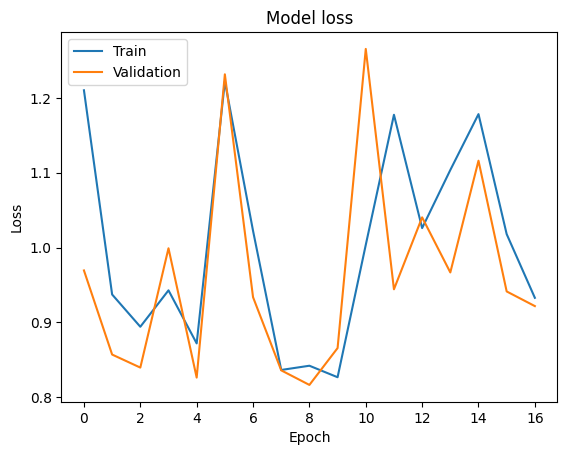

In [7]:
# Define hyperparameters best lr 0.001
learning_rates = [0.001]
dropout_rates = [0.3]
n_units = [10]

# Loop over hyperparameters
for i in range(len(learning_rates)):
    lr = learning_rates[i]
    dropout_rate = dropout_rates[i]

    early_stopping = EarlyStopping(monitor='val_loss', patience=8,restore_best_weights=True)
    optimizer = Adam(learning_rate=lr)

    model = Sequential()
    model.add(LSTM(10, input_shape=(window_size, n_features), return_sequences=False)) #n of unities hyperparameter?
    model.add(Dropout(dropout_rate))

    # Crea un nuovo modello che restituisce l'output del livello LSTM
    layer_name = 'lstm'  # Sostituisci con il nome del tuo livello LSTM se diverso
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

1887/1887 [==============================] - 10s 5ms/step


<ipython-input-8-40108c9b1dba>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(class_labels))  # Puoi scegliere una diversa mappa di colori se preferisci


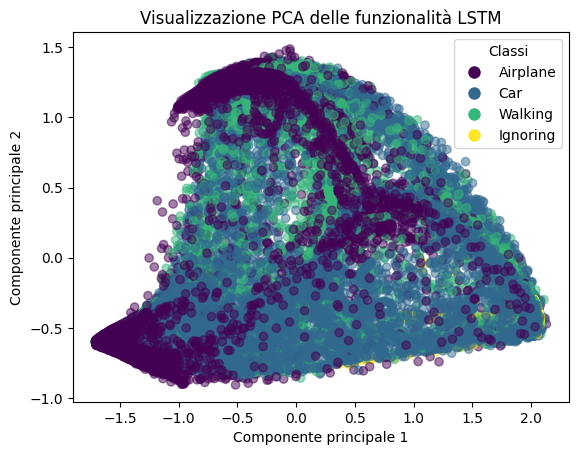

In [8]:
# Ottieni le funzionalità LSTM per i dati di addestramento
lstm_features_train = intermediate_layer_model.predict(X_train)

# Inizializza PCA con 2 componenti
pca = PCA(n_components=2)

# Adatta PCA alle funzionalità di addestramento e trasforma solo le funzionalità di addestramento
pca_result_train = pca.fit_transform(lstm_features_train)

# Ottieni le etichette di classe vere per i dati di training
true_classes_train = np.argmax(y_train, axis=1)

# Traccia i risultati solo per i dati di training
plt.figure()
plt.scatter(pca_result_train[:, 0], pca_result_train[:, 1], c=true_classes_train, alpha=0.5)
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
# Crea una lista di etichette per le classi
class_labels = ['Airplane', 'Car', 'Walking', 'Ignoring']  # Sostituisci con le tue etichette

# Crea un elenco di colori corrispondenti alle classi
colors = plt.cm.get_cmap('viridis', len(class_labels))  # Puoi scegliere una diversa mappa di colori se preferisci

# Crea un handle per ogni classe e colore
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=colors(i), markersize=10) for i, label in enumerate(class_labels)]

# Aggiungi la legenda al grafico
plt.legend(handles=handles, title='Classi')
plt.title('Visualizzazione PCA delle funzionalità LSTM')
plt.show()

In [10]:
predictions = model.predict(X_test)

# Convertire le predizioni in etichette di classe
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Stampare le predizioni
print("Predizioni:", predicted_classes)
print("Classi Vere:", true_classes)

# Calcolare l'accuratezza
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {accuracy}')
classification_rep = classification_report(true_classes, predicted_classes)
print(f'Classification Report:\n{classification_rep}')
# Calcolare la matrice di confusione
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)



524/524 [==============================] - 2s 4ms/step
Predizioni: [3 3 3 ... 2 2 2]
Classi Vere: [3 3 3 ... 0 0 0]
Accuracy: 0.7713330946413653
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.43      0.60      3717
           1       0.88      0.79      0.83      5782
           2       0.67      0.92      0.78      4555
           3       0.69      0.94      0.80      2704

    accuracy                           0.77     16758
   macro avg       0.81      0.77      0.75     16758
weighted avg       0.82      0.77      0.76     16758

Confusion Matrix:
[[1613  266 1643  195]
 [   0 4570  432  780]
 [  21  184 4209  141]
 [   0  170    0 2534]]
